# Environment Sanity Check #

Click the _Runtime_ dropdown at the top of the page, then _Change Runtime Type_ and confirm the instance type is _GPU_.

Check the output of `!nvidia-smi` to make sure you've been allocated a Tesla T4, P4, or P100.

In [1]:
!nvidia-smi

Mon May 17 07:56:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Setup:
Set up script installs
1. Install most recent Miniconda release compatible with Google Colab's Python install  (3.7.10)
1. removes incompatible files
1. Install RAPIDS' current stable version of its libraries, including:
  1. cuDF
  1. cuML
  1. cuGraph
  1. cuSpatial
  1. cuSignal
  1. xgboost
1. Set necessary environment variables
1. Copy RAPIDS .so files into current working directory, a workaround for conda/colab interactions


In [2]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable

import sys, os, shutil

sys.path.append('/usr/local/lib/python3.7/site-packages/')
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ["CONDA_PREFIX"] = "/usr/local"
for so in ['cudf', 'rmm', 'nccl', 'cuml', 'cugraph', 'xgboost', 'cuspatial']:
  fn = 'lib'+so+'.so'
  source_fn = '/usr/local/lib/'+fn
  dest_fn = '/usr/lib/'+fn
  if os.path.exists(source_fn):
    print(f'Copying {source_fn} to {dest_fn}')
    shutil.copyfile(source_fn, dest_fn)
# fix for BlazingSQL import issue
# ImportError: /usr/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.26' not found (required by /usr/local/lib/python3.7/site-packages/../../libblazingsql-engine.so)
if not os.path.exists('/usr/lib64'):
    os.makedirs('/usr/lib64')
for so_file in os.listdir('/usr/local/lib'):
  if 'libstdc' in so_file:
    shutil.copyfile('/usr/local/lib/'+so_file, '/usr/lib64/'+so_file)
    shutil.copyfile('/usr/local/lib/'+so_file, '/usr/lib/x86_64-linux-gnu/'+so_file)

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 238, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 238 (delta 36), reused 11 (delta 5), pack-reused 171
Receiving objects: 100% (238/238), 73.89 KiB | 14.78 MiB/s, done.
Resolving deltas: 100% (98/98), done.
PLEASE READ
********************************************************************************************************
Changes:
1. IMPORTANT SCRIPT CHANGES: Colab has updated to Python 3.7, and now runs our STABLE and NIGHTLY versions (0.19 and 0.20)!  PLEASE update your older install script code as follows:
	!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.19

	import sys, os, shutil

	sys.path.append('/usr/local/lib/python3.7/site-packages/')
	os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
	os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
	os.environ['CONDA_PREFIX'] = '/usr/local'
	for so in ['cudf', 'rmm',

# Use Case - BitCoin Price Prediction #

In [3]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [4]:
import cudf

In [5]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=2000')
hist = cudf.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = cudf.to_datetime(hist.index, unit='s')
target_col = 'close'

In [38]:
hist.head()

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2015-11-25,437.70,425.59,425.59,74.89,33115.18,437.70
2015-11-26,476.89,437.51,437.70,109.25,49659.07,464.79
2015-11-27,482.96,461.29,464.79,61.89,29873.62,477.79
2015-11-28,480.67,472.38,477.79,51.19,25443.06,474.23
2015-11-29,492.00,474.23,474.23,28.47,14158.57,492.00


In [39]:
hist = hist.drop(columns = ['conversionType','conversionSymbol'])
hist.head(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2015-11-25,437.70,425.59,425.59,74.89,33115.18,437.70
2015-11-26,476.89,437.51,437.70,109.25,49659.07,464.79
2015-11-27,482.96,461.29,464.79,61.89,29873.62,477.79
2015-11-28,480.67,472.38,477.79,51.19,25443.06,474.23
2015-11-29,492.00,474.23,474.23,28.47,14158.57,492.00


In [7]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [8]:
train, test = train_test_split(hist, test_size=0.2)

In [9]:
train_pd = train.to_pandas()
test_pd = test.to_pandas()

In [10]:

def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

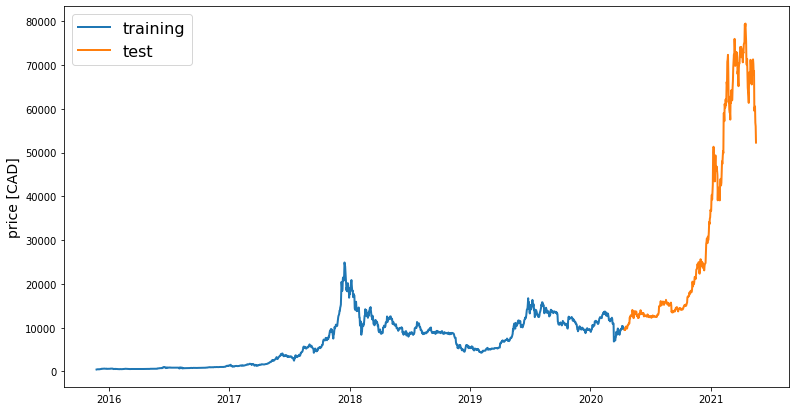

In [11]:

line_plot(train_pd[target_col], test_pd[target_col], 'training', 'test', title='')

In [12]:
def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

In [13]:
train.min()

high            437.70
low             101.20
open            425.59
volumefrom       12.15
volumeto      12392.46
close           437.70
dtype: float64

In [14]:
def normalise_zero_base(df):
    return cudf.DataFrame(df.values / df.values[0] - 1)

In [15]:
import cupy as cp

def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return cp.array(window_data)

In [16]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [17]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [18]:

np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [19]:

train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [46]:
  #https://stackoverflow.com/questions/63049620/module-keras-backend-has-no-attribute-tensorflow-backend
import tensorflow as tf
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [47]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [48]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6341739278621047498
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14404209920
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8757549115964268671
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [49]:
#arr_tf = tf.experimental.dlpack.from_dlpack(train.to_dlpack())
import tensorflow as tf
#sess.run(fetches)
#arr_cupy = cp.fromDlpack(train.to_dlpack())
arr_tf_xt = tf.experimental.dlpack.from_dlpack(X_train.toDlpack())

#arr_cupy = cp.fromDlpack(train.to_dlpack())
arr_tf_yt = tf.experimental.dlpack.from_dlpack(y_train.toDlpack())



In [50]:
model = build_lstm_model(
    arr_tf_xt, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    arr_tf_xt, arr_tf_yt, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
50/50 [==============================] - 33s 3ms/step - loss: 0.0105
Epoch 2/20
50/50 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 3/20
50/50 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 4/20
50/50 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 5/20
50/50 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 6/20
50/50 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 7/20
50/50 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 8/20
50/50 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 9/20
50/50 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 10/20
50/50 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 11/20
50/50 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 12/20
50/50 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 13/20
50/50 [=============================

In [51]:
arr_tf_xtest = tf.experimental.dlpack.from_dlpack(X_test.toDlpack())

In [52]:
arr_tf_ytest = tf.experimental.dlpack.from_dlpack(y_test.toDlpack())

In [53]:

targets = test[target_col][window_len:]
preds = model.predict(arr_tf_xtest).squeeze()
mean_absolute_error(preds, arr_tf_ytest)

0.028300751124918887

In [54]:
testcd = test.to_pandas()
targetscd = targets.to_pandas()

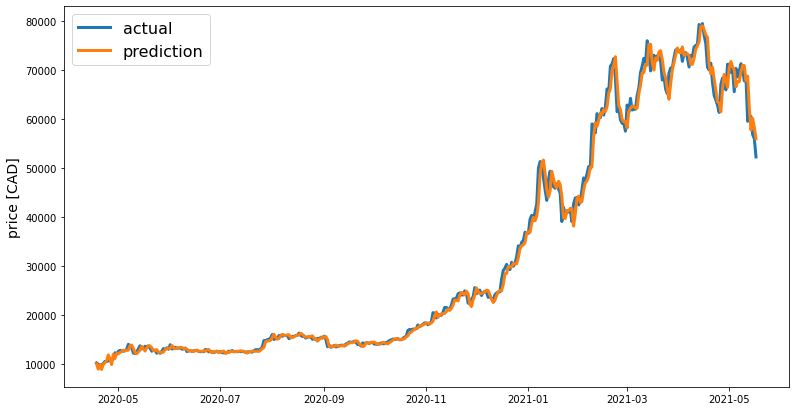

In [55]:
preds = testcd[target_col].values[:-window_len] * (preds + 1)
preds = cudf.Series(index=targets.index, data=preds)
predscd = preds.to_pandas()
line_plot(targetscd, predscd , 'actual', 'prediction', lw=3)